<h2>Prediction of time series with different neural networks architectures</h2>

In this notebook we will use different network architectures to predict the next steps for a time series. We compare:

- 1D causal convolutional networks
- 1D causal convolutional networks witho dilation rate
- RNNs
- LSTMs

We forecast a time series for longer times than we trained them on and compare the results of the different architectures. The goal is to capture the longterm dependencies of the time series.

In [1]:
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
    %tensorflow_version 2.x
except:
    IN_COLAB = False
IN_COLAB

False

In [2]:
# load required libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Lambda, Convolution1D,LSTM, SimpleRNN
tf.__version__

'2.0.0'

<h2>Simulate some data</h2>

We produce training data with two different time scales and a bit of noise. This produces 1000 curves which all follow the same pattern: a fast changing sine wave where the amplitude is modulated by a sine wave with lower frequency. To make it a bit more challenging, we add some noise at each timestep of the waves. All of the 1000 waves have the same pattern, however, the starting point is randomly shifted in time. One such example is shown the plot below. The first 128 data points are used as an input to the model (shown as a line). The model should predict the following 10 data points (shown as points). Note that the future data does not follow a smooth curve, but instead is ragged because of the random noise present in the data.

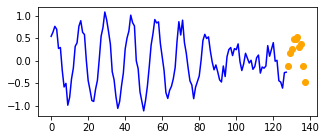

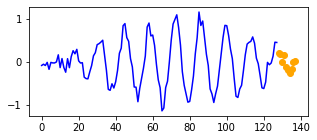

The training data X (solid) line and the next predictions Y (dotted), which should be forecasted.


In [3]:
seq_length = 128  # Sequence length used for training
look_ahead =  10  # The number of data points the model should predict 


def gen_data(size=1000, noise=0.1): # We create 1000 data-points
  s = seq_length + look_ahead
  d = np.zeros((size, s,1))
  for i in range(size):
    start = np.random.uniform(0, 2*np.pi) # Random start point
    d[i,:,0] = np.sin(start + np.linspace(0, 20*np.pi, s)) * np.sin(start + np.linspace(0, np.pi, s)) + np.random.normal(0,noise,s)
  return d[:,0:seq_length], d[:,seq_length:s]


X,Y = gen_data()
for i in range(2):
  plt.figure(num=None, figsize=(5,2))  
  plt.plot(range(0, seq_length),X[i,:,0],'b-')
  plt.plot(range(seq_length, seq_length + look_ahead),Y[i,:,0],'bo',color='orange')

plt.show()
print('The training data X (solid) line and the next predictions Y (dotted), which should be forecasted.')

<h1>A) 1D Convolution without dilation rate</h1>

<h3>Build network</h3>

Here we define a Neural network with 1D convolutions and "causal" padding.

Build a first model using the causal convolutions. Don't specify the sequence length (batch_input_shape=(None, None, 1)), so you can use a different sequence length in prediction later. The network should have 4, 1-dimensional convolutional layers, with a kernelsize of ks=5 and 32 feartures. Use the keras function `Convolution1D` for that. The network should report 10 values that the end. You can achive this with the function.

    {pyhon}
    def slice(x, slice_length):
        return x[:,-slice_length:,:]
    ...
    model1.add(Lambda(slice, arguments={'slice_length':look_ahead}))

Which you add at the end of the network.

Use the first 800 sequences for training and the last 200 for validation. As loss function we use the mean squared error (MSE). You should get a MSE of approx 0.02 to 0.03.

In [4]:
def slice(x, slice_length):
    return x[:,-slice_length:,:]

In [5]:
X,Y = gen_data()
model = Sequential()
model.add(Convolution1D(32, kernel_size=5, padding='causal', batch_input_shape=(None, None, 1)))
model.add(Convolution1D(32, kernel_size=5, padding='causal'))
model.add(Convolution1D(32, kernel_size=5, padding='causal'))
model.add(Convolution1D(32, kernel_size=5, padding='causal'))
model.add(Dense(1))
model.add(Lambda(slice, arguments={'slice_length':look_ahead}))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
dense (Dense)                (None, None, 1)           33        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0         
Total params: 15,681
Trainable params: 15,681
Non-trainable params: 0
____________________________________________________

In [7]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [8]:
history = model.fit(X[:800], Y[:800],
          epochs=10,
          validation_data=(X[800:], Y[800:]))

Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 2s 2ms/sample - loss: 0.0781 - val_loss: 0.0459
Epoch 2/10
800/800 [==============================] - 0s 494us/sample - loss: 0.0363 - val_loss: 0.0304
Epoch 3/10
800/800 [==============================] - 0s 554us/sample - loss: 0.0299 - val_loss: 0.0271
Epoch 4/10
800/800 [==============================] - 1s 989us/sample - loss: 0.0269 - val_loss: 0.0255
Epoch 5/10
800/800 [==============================] - 1s 1ms/sample - loss: 0.0264 - val_loss: 0.0260
Epoch 6/10
800/800 [==============================] - 1s 1ms/sample - loss: 0.0256 - val_loss: 0.0248
Epoch 7/10
800/800 [==============================] - 1s 1ms/sample - loss: 0.0252 - val_loss: 0.0266
Epoch 8/10
800/800 [==============================] - 1s 1ms/sample - loss: 0.0255 - val_loss: 0.0249
Epoch 9/10
800/800 [==============================] - 1s 1ms/sample - loss: 0.0249 - val_loss: 0.0242
Epoch 10/10
800/800 [=========

<h3>Make repeated predictions</h3>

Since we work with simulated data, we can produce as much new data as we like. We can also switch off the noise and check how well the model can extract the real underlying pattern in the data.

In [9]:
x_test,y_test = gen_data(size=1,noise=0.0)
print(x_test.shape)
print(y_test.shape)
pred = model.predict(x_test).reshape(-1)#Predicts 10 value

pred = pred.reshape(1,look_ahead,1)
np.concatenate((x_test, pred), axis=1).shape

(1, 128, 1)
(1, 10, 1)


(1, 138, 1)

Write a function which predicts 10 values from a starting sequence of size 128. Then add these predicted values to the starting sequence and uses this sequence of length 138 as a new starting sequence. Repeat this procedure 12 times. You should get a prediction for 120 time points in the future.

In [10]:
def predict_values(starting_sequence, repeats=12):
    x_test = starting_sequence
    for _ in range(repeats):
        pred = model.predict(x_test).reshape(-1).reshape(1,look_ahead,1)
        x_test = np.concatenate((x_test, pred), axis=1)
    return x_test

In [11]:
x_test,y_test = gen_data(size=1,noise=0.0)
values = predict_values(x_test)
x = np.zeros(values.shape)
x[0,:seq_length,0] = x_test[0,:,0]
values.shape

(1, 248, 1)

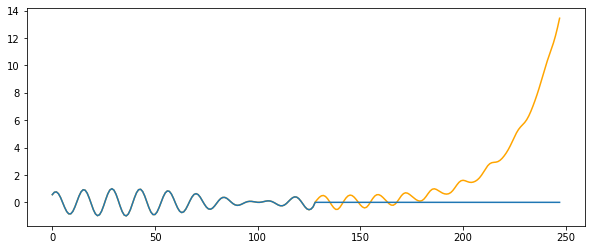

In [21]:
plt.figure(num=None, figsize=(10,4))  

plt.plot(values[0,:,0], color='orange')
plt.plot(x[0,:,0])
plt.show()

<h1>B) 1D Convolution with dilation rate</h1>

Here we define a Neural network with 1D convolutions and "causal" padding, this time with dilation rate, so we are able to look back longer in time 



Build the same network as in A) but this time with dilation_rates 1,2,4,8

In [13]:
X,Y = gen_data()
modelB = Sequential()
modelB.add(Convolution1D(32, kernel_size=5, dilation_rate=1, padding='causal', batch_input_shape=(None, None, 1)))
modelB.add(Convolution1D(32, kernel_size=5, dilation_rate=2, padding='causal'))
modelB.add(Convolution1D(32, kernel_size=5, dilation_rate=4, padding='causal'))
modelB.add(Convolution1D(32, kernel_size=5, dilation_rate=8, padding='causal'))
modelB.add(Dense(1))
modelB.add(Lambda(slice, arguments={'slice_length':look_ahead}))

In [14]:
modelB.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, None, 32)          192       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           33        
_________________________________________________________________
lambda_1 (Lambda)            (None, None, 1)           0         
Total params: 15,681
Trainable params: 15,681
Non-trainable params: 0
__________________________________________________

In [15]:
modelB.compile(optimizer='adam', loss='mean_squared_error')

In [16]:
historyB = modelB.fit(X[:800], Y[:800],
          epochs=10,
          validation_data=(X[800:], Y[800:]))

Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 4s 5ms/sample - loss: 0.0358 - val_loss: 0.0141
Epoch 2/10
800/800 [==============================] - 1s 1ms/sample - loss: 0.0144 - val_loss: 0.0128
Epoch 3/10
800/800 [==============================] - 1s 1ms/sample - loss: 0.0127 - val_loss: 0.0126
Epoch 4/10
800/800 [==============================] - 1s 1ms/sample - loss: 0.0130 - val_loss: 0.0125
Epoch 5/10
800/800 [==============================] - 1s 1ms/sample - loss: 0.0125 - val_loss: 0.0123
Epoch 6/10
800/800 [==============================] - 1s 1ms/sample - loss: 0.0121 - val_loss: 0.0128
Epoch 7/10
800/800 [==============================] - 1s 1ms/sample - loss: 0.0121 - val_loss: 0.0127
Epoch 8/10
800/800 [==============================] - 1s 2ms/sample - loss: 0.0119 - val_loss: 0.0121
Epoch 9/10
800/800 [==============================] - 1s 1ms/sample - loss: 0.0121 - val_loss: 0.0123
Epoch 10/10
800/800 [===============

<h3>Make repeated predictions</h3>

As in A) make preaded preditions on noise less data.

In [17]:
def predict_values(starting_sequence, repeats=12):
    x_test = starting_sequence
    for _ in range(repeats):
        pred = modelB.predict(x_test).reshape(-1).reshape(1,look_ahead,1)
        x_test = np.concatenate((x_test, pred), axis=1)
    return x_test

In [18]:
x_test,y_test = gen_data(size=1,noise=0.0)
valuesB = predict_values(x_test)
xB = np.zeros(values.shape)
xB[0,:seq_length,0] = x_test[0,:,0]

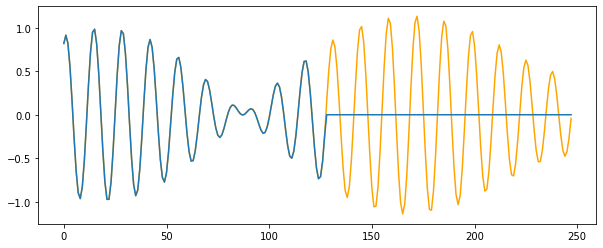

In [20]:
plt.figure(num=None, figsize=(10,4))  

plt.plot(valuesB[0,:,0], color='orange')
plt.plot(xB[0,:,0])
plt.show()

<h1>C) Simple RNN</h1>

Now, use a RNN cell Keras SimpleRNN to see if we are able to learn the data generating process. Start with a hidden state size of 12. Repeat the task from A) and B). Consider to add several layers of cells and play with the state size.